In [1]:
!pip install wordcloud
!pip install nltk
!pip install transformers==3.0.2
!pip install torch
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset
from transformers import BertTokenizer
from transformers import DistilBertTokenizer, DistilBertModel
import warnings
from torch.utils.data import TensorDataset
warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
columns = ['target', 'id', 'date', 'flag', 'user', 'text']
dataset = pd.read_csv("/content/drive/My Drive/Colab_notebooks/Datasets/training.1600000.processed.noemoticon.csv",encoding='ISO-8859-1',header=None, names=columns)
dataset.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
dataset['text'] = dataset['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)
dataset['target'] = np.where(dataset['target']==4, 1, 0)

In [5]:
dataset = dataset.drop_duplicates(subset=['text'])
dataset = dataset[['text', 'target']]

In [6]:
dataset.head()

,text,target
0,@switchfoot - A that's a bummer. You shoulda...,0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [7]:
dataset_negatives = dataset[dataset.target==0].head(10000)
dataset_positives = dataset[dataset.target==1].head(10000)
dataset = dataset_positives.append(dataset_negatives).reset_index(drop=True)

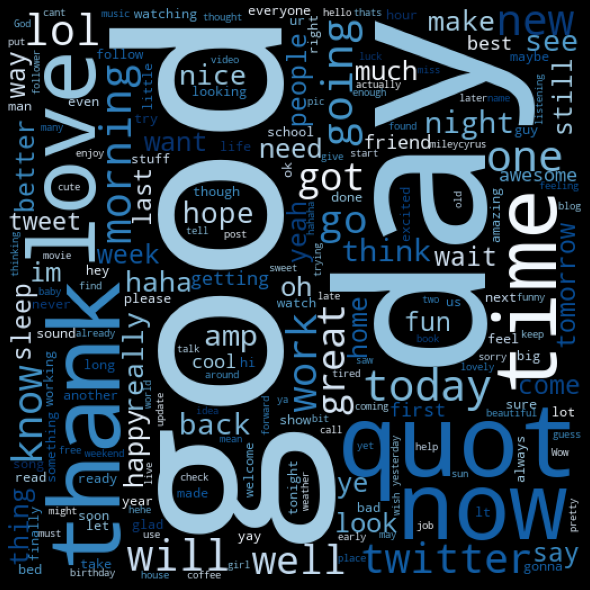

In [8]:
depressive_words = ' '.join(list(dataset[dataset['target'] == 1]['text']))
depressive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(depressive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(depressive_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

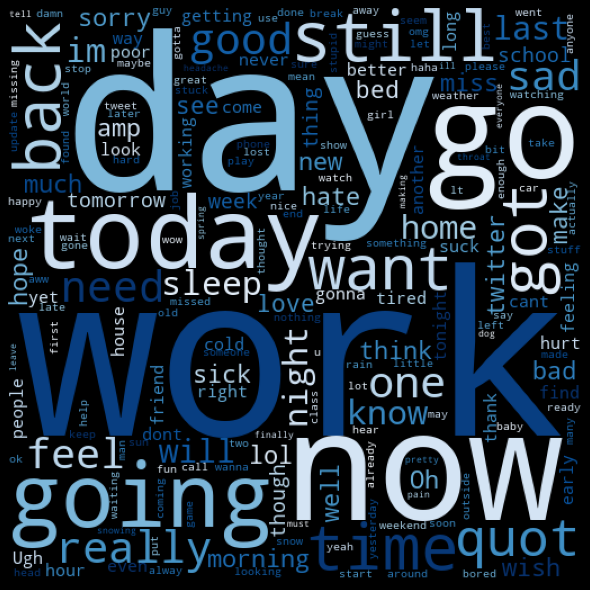

In [9]:
positive_words = ' '.join(list(dataset[dataset['target'] == 0]['text']))
positive_wc = WordCloud(width = 512,height = 512, collocations=False, colormap="Blues").generate(positive_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(positive_wc)
plt.axis('off'), 
plt.tight_layout(pad = 0)
plt.show()

In [10]:
X = dataset['text']
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [11]:
%%capture output
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case = True)

encoder_train = tokenizer.batch_encode_plus(X_train.values,
                                           add_special_tokens = True,return_attention_masks = True,
                                           pad_to_max_length = True,truncation=True,
                                           max_length = 128,
                                           return_tensors = 'pt')



encoder_test = tokenizer.batch_encode_plus(X_test.values,
                                           add_special_tokens = True,return_attention_masks = True,
                                           pad_to_max_length = True,truncation=True,
                                           max_length = 128,
                                           return_tensors = 'pt')

input_ids_train = encoder_train['input_ids']
attention_masks_train = encoder_train["attention_mask"]
labels_train = torch.tensor(y_train.values)


input_ids_test = encoder_test['input_ids']
attention_masks_test = encoder_test["attention_mask"]
labels_test = torch.tensor(y_test.values)

In [12]:
data_train = TensorDataset(input_ids_train,attention_masks_train,labels_train)
data_test = TensorDataset(input_ids_test,attention_masks_test,labels_test)

In [13]:
# from transformers import BertForSequenceClassification
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',
#                                      num_labels = len(dict_label),
                                     output_attentions = False,
                                     output_hidden_states =  False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [14]:
from torch.utils.data import RandomSampler,SequentialSampler,DataLoader

dataloader_train = DataLoader(
    data_train,
    sampler= RandomSampler(data_train),
    batch_size = 16
    
)


dataloader_test = DataLoader(
    data_test,
    sampler= RandomSampler(data_test),
    batch_size = 32
    
)

In [21]:
from transformers import AdamW,get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),lr = 1e-5,eps = 1e-8)

epochs  = 2
scheduler = get_linear_schedule_with_warmup(
            optimizer,
    num_warmup_steps = 0,
   num_training_steps = len(dataloader_train)*epochs 
)

In [16]:
from sklearn.metrics import f1_score 

def f1_score_func(preds,labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,preds_flat,average = 'weighted')


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Loading:{device}")

Loading:cuda


In [22]:
def evaluate(dataloader_val):
    model.eval()
    
    loss_val_total = 0
    predictions,true_vals = [],[]
    
    for batch in tqdm(dataloader_val):
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':  batch[0],
                  'attention_mask':batch[1],
                  'labels': batch[2]
                 }
        with torch.no_grad():
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total +=loss.item()
        
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        
    loss_val_avg = loss_val_total/len(dataloader_val)  
    
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0) 
    return loss_val_avg,predictions,true_vals

In [23]:
for epoch in tqdm(range(1,epochs+1)):
    model.train()
    
    loss_train_total=0
    
    progress_bar = tqdm(dataloader_train,desc = "Epoch: {:1d}".format(epoch),leave = False,disable = False)
    
    
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            "input_ids":batch[0],
            "attention_mask":batch[1],
            "labels":batch[2]
            
        }
        outputs = model(**inputs)
        
        loss = outputs[0]
#         logits = outputs[1]
        loss_train_total +=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
#     torch.save(model.state_dict(),f'/kaggle/output/BERT_ft_epoch{epoch}.model')To save the model after each epoch
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training Loss: {loss_train_avg}')
    val_loss,predictions,true_vals = evaluate(dataloader_test)
    test_score = f1_score_func(predictions,true_vals)
    tqdm.write(f'Val Loss:{val_loss}\n Test Score:{test_score}')


Epoch {epoch}
Training Loss: 0.4318637401983142



Val Loss:0.416529788017273
 Test Score:0.8157989097970197



Epoch {epoch}
Training Loss: 0.3460214881449938



Val Loss:0.4218321096897125
 Test Score:0.8193237875026949



In [24]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [25]:
_,predictions,true_vals = evaluate(dataloader_test)

In [51]:
from sklearn.metrics import f1_score
def accuracy_per_class(preds,labels):
    dict_label = {'happy': 0,'sad': 1}
    label_dict_reverse = {v:k for k,v in dict_label.items()}
    # label_dict_reverse = {'0', '1'}
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    print(f"Class:{label_dict_reverse}")
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f"Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n")

In [52]:
accuracy_per_class(predictions,true_vals)

Class:{0: 'happy', 1: 'sad'}
Accuracy:1692/2084

Accuracy:1585/1916

